<a href="https://colab.research.google.com/github/hyunjaec/MScA_Deep_Learning_Project/blob/main/zoning_satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
from scipy import ndimage, signal as sg
from skimage import data, filters, io, color
from sklearn.model_selection import train_test_split
from PIL import Image
import glob
import cv2
# from google.colab.patches import cv2_imshow
import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten,BatchNormalization, Input, ZeroPadding2D
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
!pwd

In [ ]:
#connect colab with google drive
from google.colab import drive
drive.mount('/content/drive')

In [125]:
austin_df = pd.read_csv('austin_zones.csv')
austin_df = austin_df.drop('Unnamed: 0', axis = 1)
austin_df.head()

,image_name,zoning_id,zoning_zty,zone
0,data/austin_0.jpg,229791,PUD,S
1,data/austin_1.jpg,229791,PUD,S
2,data/austin_2.jpg,400523442,I-RR,R
3,data/austin_3.jpg,229791,PUD,S
4,data/austin_4.jpg,229791,PUD,S


(array([1235.,    0.,    0., 1747.,    0.,    0.,  446.,    0.,    0.,
         239.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

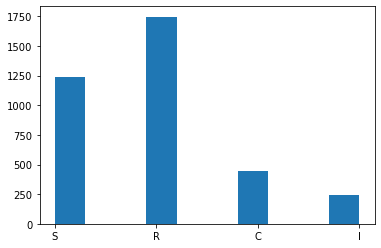

In [126]:
plt.hist(austin_df['zone'])

In [127]:
img_names = austin_df['image_name']

In [128]:
dim = (150, 150)

In [129]:
img_df = []
# for i in img_names:
#     img_df.append(cv2.imread(('../'+ str(i))))
for i, img in enumerate(img_names):
    visual_img = image.load_img(('../'+img), target_size=dim)
    img_array = image.img_to_array(visual_img)
    img_df.append(img_array)

In [130]:
img_array = np.array(img_df)

In [131]:
img_array.shape

(3667, 150, 150, 3)

In [132]:
labels = pd.get_dummies(austin_df['zone'])
X_train, X_test, y_train, y_test = train_test_split(img_array, labels, test_size=.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2933, 150, 150, 3)
(734, 150, 150, 3)
(2933, 4)
(734, 4)


In [133]:
input_shape = (150, 150, 3)

In [15]:
# img_df = np.array(img_df) 
# zone_class = np.array(austin_df['zone'])
# zone_class = pd.get_dummies(zone_class)
# #split labels and images for train&test
# X_train, X_test, y_train, y_test = train_test_split(img_array, austin_df['Zone'], test_size=.2)
# input_shape = (100, 100, 3)

In [134]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2933, 150, 150, 3)
(734, 150, 150, 3)
(2933, 4)
(734, 4)


In [135]:
print(X_train.max())
print(X_train.min())
print(X_test.max())
print(X_test.min())

255.0
0.0
255.0
0.0


In [136]:
X_train = X_train / 255
X_test = X_test / 255

In [137]:
print(X_train.max())
print(X_train.min())
print(X_test.max())
print(X_test.min())

1.0
0.0
1.0
0.0


In [138]:
datagen = ImageDataGenerator(
#     rotation_range=30,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     validation_split=0.2
    
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
    )

datagen.fit(X_train)

In [32]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(3, 3),
                 strides = (1, 1),
                 activation='relu', 
                 input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(4, activation='softmax'))


In [183]:
def base_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu", input_shape=input_shape))
    model.add(Conv2D(32, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D((2,2)))
    model.add(Conv2D(64, kernel_size=(5,5), padding="same", activation="relu"))
    model.add(Conv2D(64, kernel_size=(5,5), padding="same", activation="relu"))
    model.add(Dropout(0.1))
    model.add(MaxPooling2D((2,2)))
#     model.add(BatchNormalization())
#     model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
#     model.add(Conv2D(128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Flatten())
    model.add(Dense(32, activation="relu"))
#     model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(4, activation="softmax"))
    return model
model = base_model()

In [184]:
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_107 (Conv2D)         (None, 150, 150, 32)      896       
                                                                 
 conv2d_108 (Conv2D)         (None, 150, 150, 32)      9248      
                                                                 
 dropout_28 (Dropout)        (None, 150, 150, 32)      0         
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_109 (Conv2D)         (None, 75, 75, 64)        51264     
                                                                 
 conv2d_110 (Conv2D)         (None, 75, 75, 64)        102464    
                                                     

In [186]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss=keras.losses.categorical_crossentropy, metrics=["accuracy"])

In [187]:
batch_size = 32
epochs = 100

In [188]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'), 
                    validation_data=datagen.flow(X_train, y_train, batch_size=int(batch_size/4), subset='validation'),
                    epochs=epochs)

Epoch 1/100
74/74 [==============================] - 11s 138ms/step - loss: 40.7891 - accuracy: 0.4478 - val_loss: 1.1142 - val_accuracy: 0.4778
Epoch 2/100
74/74 [==============================] - 10s 137ms/step - loss: 1.1489 - accuracy: 0.4623 - val_loss: 1.1252 - val_accuracy: 0.4778
Epoch 3/100
74/74 [==============================] - 10s 140ms/step - loss: 1.1417 - accuracy: 0.4606 - val_loss: 1.1105 - val_accuracy: 0.4778
Epoch 4/100
74/74 [==============================] - 11s 141ms/step - loss: 1.1296 - accuracy: 0.4785 - val_loss: 1.1094 - val_accuracy: 0.5102
Epoch 5/100
74/74 [==============================] - 11s 141ms/step - loss: 1.1133 - accuracy: 0.5032 - val_loss: 1.0626 - val_accuracy: 0.5307
Epoch 6/100
74/74 [==============================] - 11s 143ms/step - loss: 1.0983 - accuracy: 0.5173 - val_loss: 1.0562 - val_accuracy: 0.5239
Epoch 7/100
74/74 [==============================] - 11s 143ms/step - loss: 1.0891 - accuracy: 0.5181 - val_loss: 1.0294 - val_accuracy

74/74 [==============================] - 11s 144ms/step - loss: 0.9978 - accuracy: 0.5935 - val_loss: 0.9745 - val_accuracy: 0.5887
Epoch 58/100
74/74 [==============================] - 10s 141ms/step - loss: 0.9923 - accuracy: 0.5803 - val_loss: 1.0052 - val_accuracy: 0.5597
Epoch 59/100
74/74 [==============================] - 10s 141ms/step - loss: 1.0001 - accuracy: 0.5773 - val_loss: 0.9647 - val_accuracy: 0.5887
Epoch 60/100
74/74 [==============================] - 11s 143ms/step - loss: 1.0163 - accuracy: 0.5722 - val_loss: 0.9974 - val_accuracy: 0.5751
Epoch 61/100
74/74 [==============================] - 10s 141ms/step - loss: 0.9851 - accuracy: 0.5824 - val_loss: 0.9689 - val_accuracy: 0.5785
Epoch 62/100
74/74 [==============================] - 11s 141ms/step - loss: 0.9849 - accuracy: 0.5880 - val_loss: 0.9715 - val_accuracy: 0.5870
Epoch 63/100
74/74 [==============================] - 11s 143ms/step - loss: 1.0172 - accuracy: 0.5837 - val_loss: 0.9695 - val_accuracy: 0.575

KeyboardInterrupt: 

In [148]:
vgg_model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = input_shape)

In [149]:
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [150]:
for layer in vgg_model.layers[:20]:
    layer.trainable = False
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [155]:
x = vgg_model.output
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
vgg_final = Model(vgg_model.input, predictions)
vgg_final.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0   

In [165]:
# compile the model 
vgg_final.compile(loss = "categorical_crossentropy", 
                    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True), metrics=["accuracy"])


In [167]:
epochs=100

In [168]:
history = vgg_final.fit(datagen.flow(X_train, y_train, batch_size=batch_size, subset='training'), 
                    validation_data=datagen.flow(X_train, y_train, batch_size=int(batch_size/4), subset='validation'),
                    epochs=epochs)

Epoch 1/100
74/74 [==============================] - 18s 243ms/step - loss: 0.7103 - accuracy: 0.7090 - val_loss: 0.9095 - val_accuracy: 0.6246
Epoch 2/100
74/74 [==============================] - 18s 243ms/step - loss: 0.7110 - accuracy: 0.7150 - val_loss: 0.8776 - val_accuracy: 0.6416
Epoch 3/100
74/74 [==============================] - 18s 244ms/step - loss: 0.7123 - accuracy: 0.7047 - val_loss: 0.9106 - val_accuracy: 0.6451
Epoch 4/100
74/74 [==============================] - 18s 245ms/step - loss: 0.7000 - accuracy: 0.7137 - val_loss: 0.9189 - val_accuracy: 0.6246
Epoch 5/100
74/74 [==============================] - 18s 245ms/step - loss: 0.6992 - accuracy: 0.7064 - val_loss: 0.9088 - val_accuracy: 0.6314
Epoch 6/100
74/74 [==============================] - 18s 246ms/step - loss: 0.6786 - accuracy: 0.7111 - val_loss: 0.9118 - val_accuracy: 0.6331
Epoch 7/100
74/74 [==============================] - 18s 249ms/step - loss: 0.6895 - accuracy: 0.7124 - val_loss: 0.9361 - val_accuracy:

74/74 [==============================] - 18s 247ms/step - loss: 0.3300 - accuracy: 0.8743 - val_loss: 1.2968 - val_accuracy: 0.5904
Epoch 58/100
74/74 [==============================] - 18s 247ms/step - loss: 0.3338 - accuracy: 0.8671 - val_loss: 1.2508 - val_accuracy: 0.5990
Epoch 59/100
74/74 [==============================] - 18s 249ms/step - loss: 0.3158 - accuracy: 0.8773 - val_loss: 1.1896 - val_accuracy: 0.6195
Epoch 60/100
74/74 [==============================] - 18s 247ms/step - loss: 0.3279 - accuracy: 0.8811 - val_loss: 1.2434 - val_accuracy: 0.6092
Epoch 61/100
74/74 [==============================] - 18s 247ms/step - loss: 0.3059 - accuracy: 0.8798 - val_loss: 1.2797 - val_accuracy: 0.6109
Epoch 62/100
74/74 [==============================] - 18s 248ms/step - loss: 0.2894 - accuracy: 0.8867 - val_loss: 1.3081 - val_accuracy: 0.5973
Epoch 63/100
74/74 [==============================] - 18s 247ms/step - loss: 0.2936 - accuracy: 0.8790 - val_loss: 1.5464 - val_accuracy: 0.619

In [62]:
# history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
#                     steps_per_epoch=len(X_train) / 32, epochs=epochs)

history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size,
                    subset='training'),
                    validation_data=datagen.flow(X_train, y_train,
                    batch_size=batch_size, subset='validation'),
                    steps_per_epoch=len(X_train) // 32, epochs=epochs)

Epoch 1/100
91/91 [==============================] - 8s 85ms/step - loss: 0.9642 - accuracy: 0.5939 - val_loss: 0.9570 - val_accuracy: 0.5853


In [53]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [46]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [59]:
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except RuntimeError as e:
  # Invalid device or cannot modify virtual devices once initialized.
  print(e)

Visible devices cannot be modified after being initialized


In [48]:
# with tf.device('/cpu:0'):
history = model.fit(x=X_train, y=y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

Epoch 1/100
74/74 [==============================] - 6s 62ms/step - loss: 3.2585 - accuracy: 0.2617 - val_loss: 1.2328 - val_accuracy: 0.4685
Epoch 2/100
74/74 [==============================] - 3s 44ms/step - loss: 1.2081 - accuracy: 0.4736 - val_loss: 1.1707 - val_accuracy: 0.4685
Epoch 3/100
74/74 [==============================] - 3s 43ms/step - loss: 1.2364 - accuracy: 0.4829 - val_loss: 1.1868 - val_accuracy: 0.4685
Epoch 4/100
74/74 [==============================] - 3s 42ms/step - loss: 1.2069 - accuracy: 0.4766 - val_loss: 1.1736 - val_accuracy: 0.4685
Epoch 5/100
74/74 [==============================] - 3s 42ms/step - loss: 1.1855 - accuracy: 0.4778 - val_loss: 1.1866 - val_accuracy: 0.4685
Epoch 6/100
74/74 [==============================] - 3s 42ms/step - loss: 1.2049 - accuracy: 0.4791 - val_loss: 1.1745 - val_accuracy: 0.4685
Epoch 7/100
74/74 [==============================] - 3s 42ms/step - loss: 1.1780 - accuracy: 0.4744 - val_loss: 1.1645 - val_accuracy: 0.4685
Epoch 

KeyboardInterrupt: 

In [171]:
score = vgg_final.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)

Test loss: [7.0591936111450195, 0.20572206377983093]


Text(0.5, 1.0, 'Loss Curves')

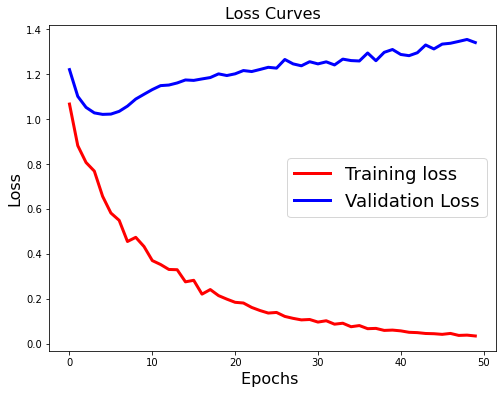

In [194]:
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

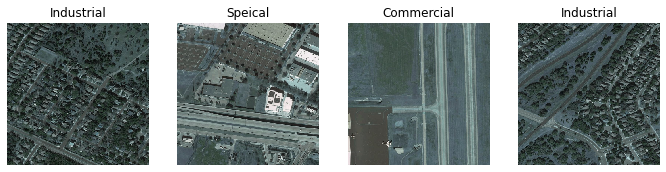

In [196]:
class_names = ['Residnetial', 'Commercial', 'Industrial','Speical']
images_and_labels = list(zip(X_test, y_test))
plt.figure(figsize=(30,30))
for index, (image, label) in enumerate(images_and_labels):
    plt.subplot(4, 10, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    index = np.where(label == 1)
    imagedata = image[np.newaxis, :, :]
    pred = model.predict(imagedata)
    pred= pred[0].argmax(axis=0)
    plt.title(class_names[pred])
plt.show()